# What's Cooking : TF-Idf + Logistic Regr


# Загрузка необходимых библиотек

In [43]:
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt 
import seaborn as sns 
import os
import nltk
from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from nltk import word_tokenize          
from nltk.stem import WordNetLemmatizer 
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score

Загрузка данных

In [5]:
train_df = pd.DataFrame(pd.read_json('G:/SublimePort/SublimePortable/SublimePortable/Test/train.json/train.json'))
test_df = pd.DataFrame(pd.read_json('G:/SublimePort/SublimePortable/SublimePortable/Test/test.json'))

Посмотрим на вид датасетов

In [6]:
print (train_df.head(5))
print (train_df.shape)
print (train_df.columns)
print (train_df.info())

      id      cuisine                                        ingredients
0  10259        greek  [romaine lettuce, black olives, grape tomatoes...
1  25693  southern_us  [plain flour, ground pepper, salt, tomatoes, g...
2  20130     filipino  [eggs, pepper, salt, mayonaise, cooking oil, g...
3  22213       indian                [water, vegetable oil, wheat, salt]
4  13162       indian  [black pepper, shallots, cornflour, cayenne pe...
(39774, 3)
Index(['id', 'cuisine', 'ingredients'], dtype='object')
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 39774 entries, 0 to 39773
Data columns (total 3 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   id           39774 non-null  int64 
 1   cuisine      39774 non-null  object
 2   ingredients  39774 non-null  object
dtypes: int64(1), object(2)
memory usage: 932.3+ KB
None


In [7]:
print (test_df.head(5))
print (test_df.shape)
print (test_df.info())

      id                                        ingredients
0  18009  [baking powder, eggs, all-purpose flour, raisi...
1  28583  [sugar, egg yolks, corn starch, cream of tarta...
2  41580  [sausage links, fennel bulb, fronds, olive oil...
3  29752  [meat cuts, file powder, smoked sausage, okra,...
4  35687  [ground black pepper, salt, sausage casings, l...
(9944, 2)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9944 entries, 0 to 9943
Data columns (total 2 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   id           9944 non-null   int64 
 1   ingredients  9944 non-null   object
dtypes: int64(1), object(1)
memory usage: 155.5+ KB
None


# Исследование датасетов

In [8]:
train_df['cuisine'].unique()

array(['greek', 'southern_us', 'filipino', 'indian', 'jamaican',
       'spanish', 'italian', 'mexican', 'chinese', 'british', 'thai',
       'vietnamese', 'cajun_creole', 'brazilian', 'french', 'japanese',
       'irish', 'korean', 'moroccan', 'russian'], dtype=object)

В нашем датасете 20 кухонь

Теперь посмотрим сколько рецептов относится к каждой кухни

In [9]:
train_df['cuisine'].value_counts()

italian         7838
mexican         6438
southern_us     4320
indian          3003
chinese         2673
french          2646
cajun_creole    1546
thai            1539
japanese        1423
greek           1175
spanish          989
korean           830
vietnamese       825
moroccan         821
british          804
filipino         755
irish            667
jamaican         526
russian          489
brazilian        467
Name: cuisine, dtype: int64

Посмотрим на чаще используемые ингредиенты

In [15]:
from collections import Counter
most_commoning = Counter([item for lists in train_df['ingredients'] for item in lists])
most_commoning.most_common(10)

[('salt', 18049),
 ('onions', 7972),
 ('olive oil', 7972),
 ('water', 7457),
 ('garlic', 7380),
 ('sugar', 6434),
 ('garlic cloves', 6237),
 ('butter', 4848),
 ('ground black pepper', 4785),
 ('all-purpose flour', 4632)]

Очень много соли

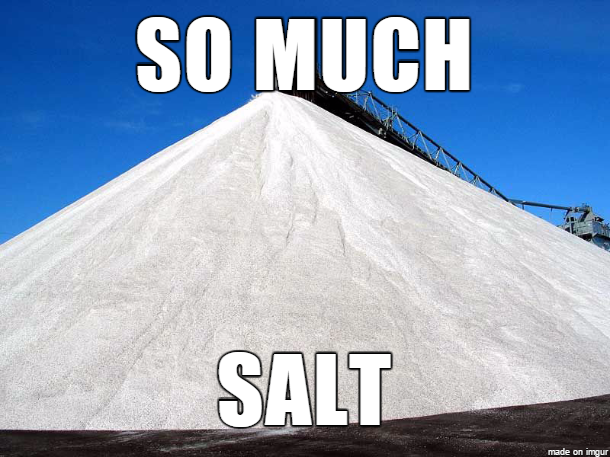

In [1]:
from IPython import display
display.Image("https://i.imgur.com/VHaVXY3.png")

Посмотрим на распределение длин рецептов

<AxesSubplot:>

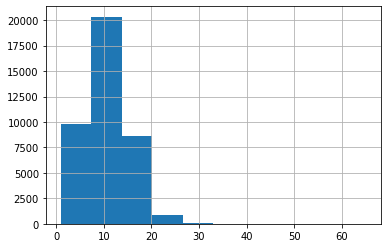

In [10]:
train_df['ingredients'].str.len().hist()

<AxesSubplot:>

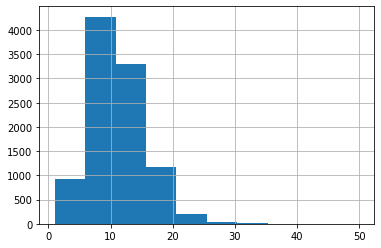

In [11]:
test_df['ingredients'].str.len().hist()

Посмотрим на распределение длин рецептов среди 6 самых больших по количеству рецептов кухонь

<AxesSubplot:>

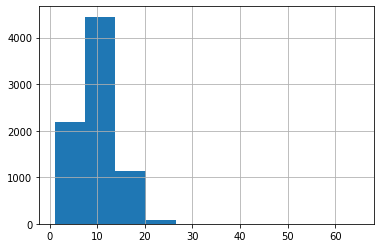

In [16]:
train_df.loc[train_df['cuisine'] == 'italian', 'ingredients'].str.len().hist()

<AxesSubplot:>

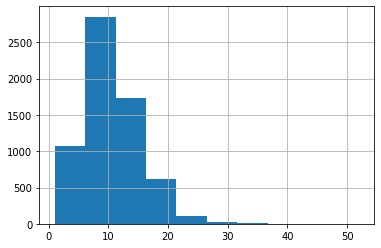

In [18]:
train_df.loc[train_df['cuisine'] == 'mexican', 'ingredients'].str.len().hist()

<AxesSubplot:>

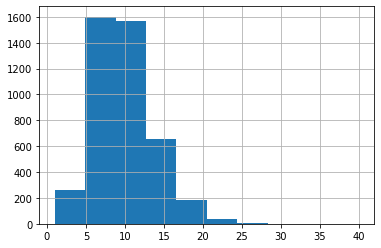

In [19]:
train_df.loc[train_df['cuisine'] == 'southern_us', 'ingredients'].str.len().hist()

<AxesSubplot:>

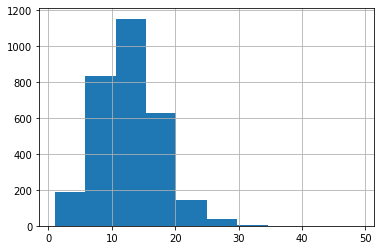

In [20]:
train_df.loc[train_df['cuisine'] == 'indian', 'ingredients'].str.len().hist()

<AxesSubplot:>

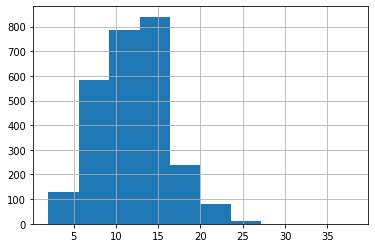

In [21]:
train_df.loc[train_df['cuisine'] == 'chinese', 'ingredients'].str.len().hist()

<AxesSubplot:>

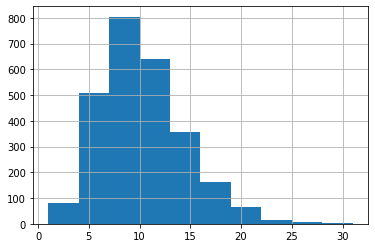

In [23]:
train_df.loc[train_df['cuisine'] == 'french', 'ingredients'].str.len().hist()

In [25]:
train_df['ingredients'].str.len().describe()

count    39774.000000
mean        10.767713
std          4.428978
min          1.000000
25%          8.000000
50%         10.000000
75%         13.000000
max         65.000000
Name: ingredients, dtype: float64

В среднем длина рецепта ~10, видны некоторые выбросы

По итогу исследований обуч. датасета можно сказать: 
1. Есть символы пунктуации (,)
2. Есть лишние символы (of , ...), которые не влияют на смысл

# Обработка данных

In [26]:
#Объедим ингредиенты в единую строку, чтобы мы могли обработать их как отдельные слова
train_df['seperated_ingredients'] = train_df['ingredients'].apply(','.join)
test_df['seperated_ingredients'] = test_df['ingredients'].apply(','.join)


0        romaine lettuce,black olives,grape tomatoes,ga...
1        plain flour,ground pepper,salt,tomatoes,ground...
2        eggs,pepper,salt,mayonaise,cooking oil,green c...
3                           water,vegetable oil,wheat,salt
4        black pepper,shallots,cornflour,cayenne pepper...
                               ...                        
39769    light brown sugar,granulated sugar,butter,warm...
39770    KRAFT Zesty Italian Dressing,purple onion,broc...
39771    eggs,citrus fruit,raisins,sourdough starter,fl...
39772    boneless chicken skinless thigh,minced garlic,...
39773    green chile,jalapeno chilies,onions,ground bla...
Name: seperated_ingredients, Length: 39774, dtype: object

Посмотрим на биграммы

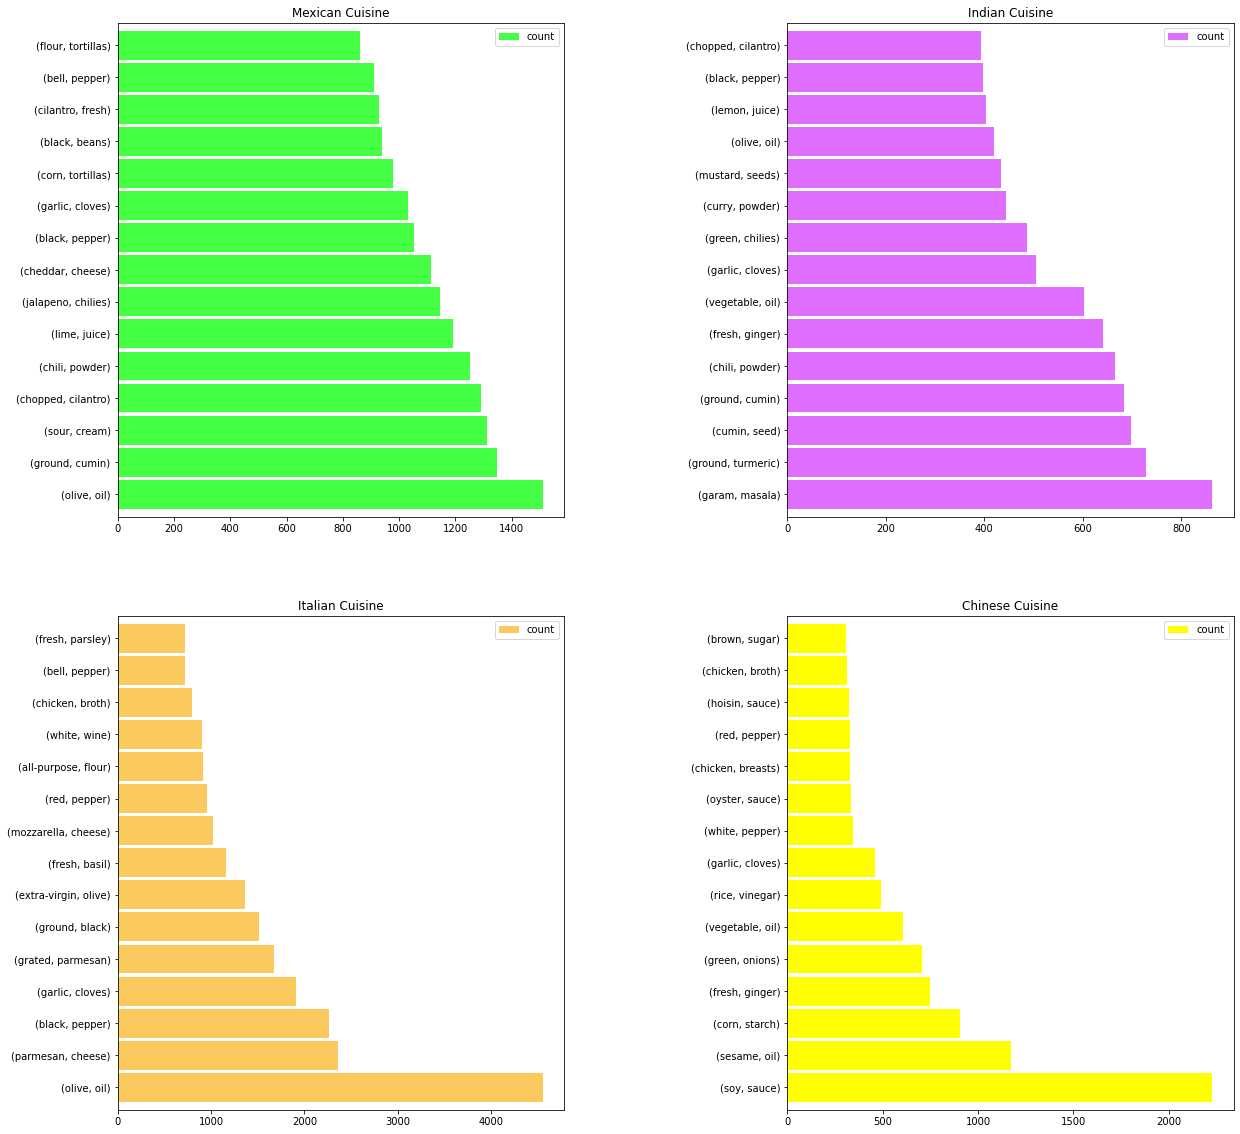

In [29]:
train_df['for ngrams']=train_df['seperated_ingredients'].str.replace(',',' ')
f,ax=plt.subplots(2,2,figsize=(20,20))
def ingre_cusine(cuisine):
    frame=train_df[train_df['cuisine']==cuisine]
    common=list(nltk.bigrams(nltk.word_tokenize(" ".join(frame['for ngrams']))))
    return pd.DataFrame(Counter(common),index=['count']).T.sort_values('count',ascending=False)[:15]
ingre_cusine('mexican').plot.barh(ax=ax[0,0],width=0.9,color='#45ff45')
ax[0,0].set_title('Mexican Cuisine')
ingre_cusine('indian').plot.barh(ax=ax[0,1],width=0.9,color='#df6dfd')
ax[0,1].set_title('Indian Cuisine')
ingre_cusine('italian').plot.barh(ax=ax[1,0],width=0.9,color='#fbca5f')
ax[1,0].set_title('Italian Cuisine')
ingre_cusine('chinese').plot.barh(ax=ax[1,1],width=0.9,color='#ffff00')
ax[1,1].set_title('Chinese Cuisine')
plt.subplots_adjust(wspace=0.5)

In [27]:
X_train, X_test, y_train, y_test = train_test_split(train_df['seperated_ingredients'], train_df['cuisine'], test_size = 0.30, random_state = 102)

Чтобы предсказать какой из кухонь принадлежит тот или иной рецепт, будет использоваться TF-Idf
Также будем применять лемматизацию, чтобы определять похожие слова, например "огурец" и "огурцы".

In [46]:
#Определяем tokenizer
class LemmaTokenizer(object):
    def __init__(self):
        self.wnl = WordNetLemmatizer()
    def __call__(self, doc):
        return [self.wnl.lemmatize(t) for t in word_tokenize(doc)]
#Определяем паттерн
pattern = r"[A-Za-z]" 
#Для скейла фичей
from sklearn.preprocessing import MaxAbsScaler
#TF-Idf
vec = TfidfVectorizer(tokenizer=LemmaTokenizer(), stop_words = 'english', lowercase = True, token_pattern = pattern, max_df = 0.1, ngram_range = (1,2))
#classifier
classifier = LogisticRegression(max_iter=7600)
#определяем Pipeline
pl = Pipeline([
     ('vec',vec), 
    ('scale', MaxAbsScaler()),
    ('classifier', classifier)])
#Помещаем данные для обучения
pl.fit(X_train, y_train)
pl.score(X_test, y_test)


C:\Users\Лавандос\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\feature_extraction\text.py:396: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['ha', 'le', 'u', 'wa'] not in stop_words.
  warnings.warn(


0.780273191988603

<AxesSubplot:>

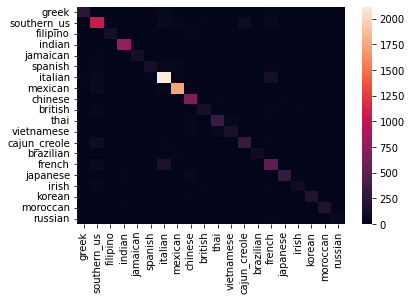

In [49]:
y_predicted = pl.predict(X_test)
# определим матрицу, чтобы посмотреть на ошибки
from sklearn.metrics import confusion_matrix

cm = pd.DataFrame(confusion_matrix(y_test, y_predicted, labels=train_df['cuisine'].unique()), index=train_df['cuisine'].unique(), columns=train_df['cuisine'].unique())

sns.heatmap(cm)

In [51]:
#Делаем предсказание на тестовом датасете
predictions = pl.predict(test_df['seperated_ingredients'])

output = pd.DataFrame(data = predictions, columns = ['cuisine'], index = test_df['id'])

output.reset_index(level=0, inplace=True) #были проблемы с выводом

output.head(5)

,id,cuisine
0,18009,irish
1,28583,southern_us
2,41580,italian
3,29752,cajun_creole
4,35687,italian
